-----------

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()


# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [3]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [4]:
g = torch.Generator().manual_seed(2147483647) #For consistency ofcourse, to keep the same values as andrej
C = torch.randn((27,2), generator=g)
W1 = torch.rand((6, 100), generator=g)
b1 = torch.rand(100, generator=g)
W2 = torch.rand((100, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [5]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = - prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(6.4365)

------------

In [ ]:
#Setting up the training of the Neural Net

In [5]:
for p in parameters:
    p.requires_grad = True #Coz we know PyTorch asks for this parameter, as it is set to false by default

In [ ]:
for _ in range(10):

    #forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

# print(loss.item())

tensor(5.9912, grad_fn=<NllLossBackward0>)
tensor(4.9723, grad_fn=<NllLossBackward0>)
tensor(4.6059, grad_fn=<NllLossBackward0>)
tensor(4.3298, grad_fn=<NllLossBackward0>)
tensor(4.1185, grad_fn=<NllLossBackward0>)
tensor(3.9586, grad_fn=<NllLossBackward0>)
tensor(3.8382, grad_fn=<NllLossBackward0>)
tensor(3.7435, grad_fn=<NllLossBackward0>)
tensor(3.6644, grad_fn=<NllLossBackward0>)
tensor(3.5960, grad_fn=<NllLossBackward0>)


### Adding mini-batches

In [10]:
for _ in range(1000):

    #Minibatch
    xi = torch.randint(0, X.shape[0], (32,))

    #forward pass
    emb = C[X[xi]]  #added for X
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[xi])   #added for Y
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

2.398618459701538


### Finding a good learning rate

In [11]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [22]:
#Everytime you wanna restart just run this to reset the parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.rand((6, 100), generator=g)
b1 = torch.rand(100, generator=g)
W2 = torch.rand((100, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [23]:
for p in parameters:
    p.requires_grad = True

In [24]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [15]:
lri = []
lossi = []

for i in range(1000):

    #Minibatch
    xi = torch.randint(0, X.shape[0], (32,))

    #forward pass
    emb = C[X[xi]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[xi])
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -0.1 * p.grad

    #keeping track
    lri.append(lr)
    lossi.append(loss.item())

print(loss.item())

2.419145107269287


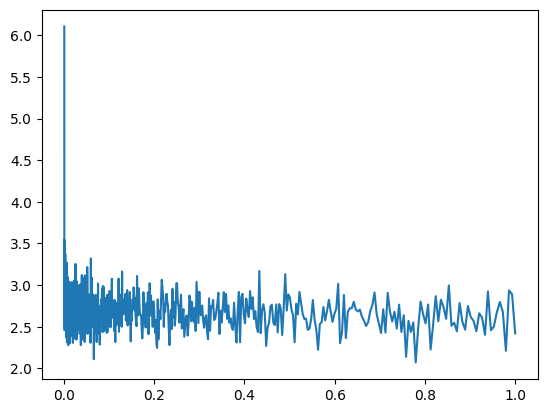

In [16]:
plt.plot(lri, lossi)

But we would like to see which exponent value is recommended to use, so we'll update the x-axis

In [20]:
#Remember to reset the parameters and only then run this

lri = []
lossi = []

for i in range(1000):

    #Minibatch
    xi = torch.randint(0, X.shape[0], (32,))

    #forward pass
    emb = C[X[xi]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[xi])
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -0.1 * p.grad

    #keeping track
    lri.append(lre[i]) #We are taking the exponent of the learning rate for the x-axis
    lossi.append(loss.item())

print(loss.item())

2.705171585083008


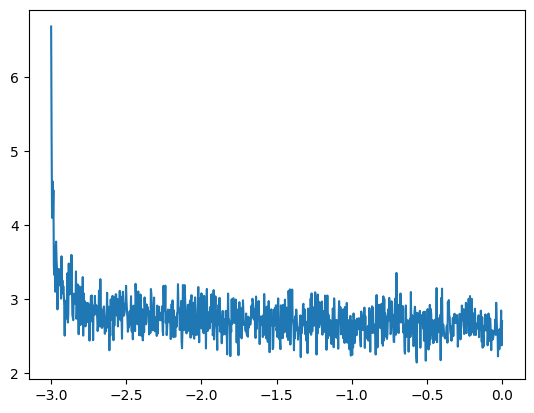

In [21]:
plt.plot(lri, lossi)

^Here exp of `-1` is the closest to where the loss is less, so exponent of -1 is 0.1, which was the actual value we had considered anyway

Just to cross-check we'll directly plot that value and see

In [25]:
#Remember to reset the parameters and only then run this

lri = []
lossi = []

for i in range(1000):

    #Minibatch
    xi = torch.randint(0, X.shape[0], (32,))

    #forward pass
    emb = C[X[xi]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[xi])
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -0.1 * p.grad

    #keeping track
    lri.append(lrs[i]) #We are taking the exponent of the learning rate for the x-axis
    lossi.append(loss.item())

print(loss.item())

2.7444117069244385


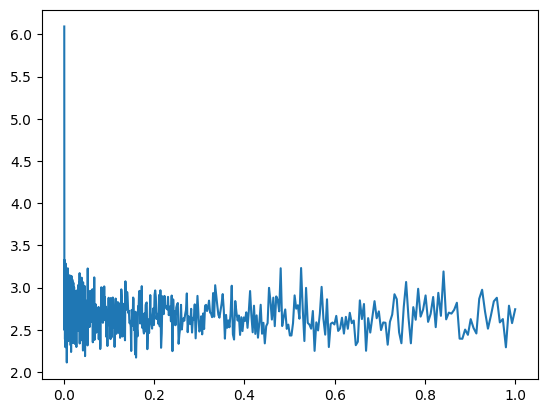

In [26]:
plt.plot(lri, lossi)

Yeah `0.1` seems fair I guess lol

---------